In [1]:
# import necessary modules
# uncomment to get plots displayed in notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class
import math

import sys 
# from help_functions import *
import os
path_to_class_sz = os.getcwd() +'/../../'

Metal device set to: Apple M1 Pro


2023-03-23 14:12:43.906916: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-23 14:12:43.907032: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
plt.rcParams["figure.figsize"] = [3.0,2.0]


# a simple conversion from cl's to dl's
def l_to_dl(lp):
    return lp*(lp+1.)/2./np.pi

# Parameters 

In [54]:
# the parameters needed for cosmology:
# use the last column of Planck 2018 (https://arxiv.org/pdf/1807.06209.pdf)
# TT,TE,EE+lowE+lensing+BAO
# cosmo_params = {
# 'omega_b': 0.02242,
# 'omega_cdm':  0.11933,
# #'H0': 67.66,
# 'h': 0.6766,
# 'tau_reio': 0.0561,
# 'ln10^{10}A_s': 3.047,
# 'n_s': 0.9665,

# 'k_pivot': 0.05,
# 'N_ncdm': 1,
# 'N_ur': 2.0328,
# 'm_ncdm': 0.06    
# }
# copied from : https://github.com/simonsobs/websky_model/blob/a93bbf758432a936c0ec2b59775683b695d3d191/websky_model/websky.py#L55
websky_Omega_M = 0.31
websky_Omega_B = 0.049
websky_Omega_L = 0.69
websky_h = 0.68
websky_sigma_8 = 0.81
websky_n_s = 0.965


websky_cosmo = {
    'omega_b': websky_Omega_B*websky_h**2.,
    'omega_cdm': (websky_Omega_M-websky_Omega_B)*websky_h**2.,
    'h': websky_h,
    'tau_reio': 0.0543,
    'sigma8': websky_sigma_8,
    'n_s': websky_n_s, 
}

In [53]:
common_params = {

'z_min' : 0.005,
'z_max' : 3.0,
'M_min' : 1.0e10, 
'M_max' : 3.5e15,
     

'mass function' : 'T08',
'delta for cib' : '200m',
'concentration parameter' : 'D08',

'redshift_epsabs': 1.0e-40,
'redshift_epsrel': 0.0005,
'mass_epsabs': 1.0e-40,
'mass_epsrel': 0.0005,


'ell_max': 10000.0,
'ell_min': 2.0,
'dlogell': 0.3,

'hm_consistency' : 0,
    

}


In [55]:
#### CIB
websky_cib_pdict = {}
websky_cib_pdict['Redshift evolution of dust temperature' ] =  0.2
websky_cib_pdict['Dust temperature today in Kelvins' ] = 20.7
websky_cib_pdict['Emissivity index of sed' ] = 1.6
websky_cib_pdict['Power law index of SED at high frequency' ] = 1.7 # not given in WebSky paper actually not relevant since we dont use high freqs in websky.
websky_cib_pdict['Redshift evolution of L − M normalisation' ] = 1.28
websky_cib_pdict['Most efficient halo mass in Msun' ] = pow(10.,12.3)
websky_cib_pdict['Normalisation of L − M relation in [Jy MPc2/Msun]' ] =  4.461102571695613e-07 # L0_websky, not given in WebSky paper
websky_cib_pdict['Size of of halo masses sourcing CIB emission' ] = 0.3
websky_cib_pdict['z_plateau_cib' ] = 2.

# M_min_HOD_cib is the threshold above which nc = 1
# centrals is Ncen = 1 for all halos with mass bigger than websky's m_min
# subhalo mass function is eq. 3.9 of the websky paper 
# it is F. Jiang and F. C. van den Bosch, Generating merger trees for dark matter haloes: a comparison of
# methods, MNRAS 440 (2014) 193 [1311.5225].
websky_cib_pdict['M_min_HOD_cib' ] = pow(10.,10.1) #is ignored
websky_cib_pdict['M_min_subhalo_in_Msun' ] = 1.0e11 # if M_min_subhalo_in_Msun is given, then M_min_HOD_cib is ignored
websky_cib_pdict['use_nc_1_for_all_halos_cib_HOD'] = 1
websky_cib_pdict['sub_halo_mass_function' ] = 'JvdB14'
#Mass bounds
websky_cib_pdict['use_redshift_dependent_M_min'] = 1
websky_cib_pdict['full_path_to_redshift_dependent_M_min'] = path_to_class_sz+"class_sz_auxiliary_files/websky_halo_mass_completion_z_Mmin_in_Msun_over_h.txt"

websky_cib_pdict['M_max' ] = 1e16*cosmo_params['h']

#for the Lsat tabulation computation, adjust so it covers the frequency range you want
websky_cib_pdict['freq_min'] = 2e2
websky_cib_pdict['freq_max'] = 6e2
# websky_cib_pdict['dlogfreq' ] = 0.05 #if request monopole

websky_cib_pdict['n_z_L_sat'] = 100
websky_cib_pdict['n_m_L_sat'] = 100
websky_cib_pdict['n_nu_L_sat'] = 100

# Select frequencies 

In [56]:
nu_list = 217,353,545
nu_list_str = '217,353,545'

## Flux cut 

In [57]:
# flux cut values

cib_flux = {}
# Planck flux cut, Table 1 in https://arxiv.org/pdf/1309.0382.pdf
cib_flux['100'] = 400
cib_flux['143'] = 350
cib_flux['217'] = 225
cib_flux['353'] = 315
cib_flux['545'] = 350
cib_flux['857'] = 710
cib_flux['3000'] = 1000
#SO, from SO foreacst
cib_flux['93'] = 7
cib_flux['145'] = 15
cib_flux['225'] = 20
cib_flux['280'] = 25
#CCAT prime, McCarthy et al.'s' assumptions
# cib_flux['93'] = 400
# cib_flux['145'] = 350
# cib_flux['225'] = 225
# cib_flux['220'] = 225
# cib_flux['280'] = 225
# cib_flux['350'] = 315
# cib_flux['550'] = 350
# cib_flux['545'] = 350
# cib_flux['850'] = 710

def make_flux_cut_list(cib_flux_dict, nu_list):
    """
    Make a string of flux cut values for given frequency list to pass into class_sz
    Beware: if frequency not in the flux_cut dictionary, it assigns 0
    """
    cib_flux_list = []
    keys = list(cib_flux.keys())
    for i,nu in enumerate(nu_list):
        if str(nu) in keys:
            cib_flux_list.append(cib_flux[str(nu)])
        else:
            cib_flux_list.append(0)
    return cib_flux_list

cib_flux_list = make_flux_cut_list(cib_flux, nu_list)
cib_flux_list

[225, 315, 350]

# Compute CIB auto 

In [58]:
%%time 
N = Class()
N.set(common_params)
N.set(websky_cosmo)
N.set(websky_cib_pdict)

N.set({# class_sz parameters:
        'output':'cib_cib_1h,cib_cib_2h',
        'class_sz_verbose':0,
        
        'cib_frequency_list_num' : len(nu_list),
        'cib_frequency_list_in_GHz' : nu_list_str,  
        'cib_Snu_cutoff_list [mJy]': str(list(cib_flux_list))[1:-1],
        'has_cib_flux_cut': 1
        })
        
N.compute()

CPU times: user 35.3 s, sys: 72.3 ms, total: 35.4 s
Wall time: 4.13 s


In [59]:
cib = N.cl_cib_cib()

ell_cib = np.asarray(cib[str(nu_list[0])+'x'+str(nu_list[0])]['ell'])

cl2dl = l_to_dl(ell_cib)

# Compare with sims data

In [60]:
path_ps = path_to_class_sz+"/class_sz_auxiliary_files/cib_files/"

# # in MJy2/sr
ell_ws, ws_cib145 = np.loadtxt(path_ps+"cl_cib_cib_145_websky_l_cl_090322.txt").T
ell_ws, ws_cib217 = np.loadtxt(path_ps+"cl_cib_cib_217_websky_l_cl_090322.txt").T
ell_ws, ws_cib353 = np.loadtxt(path_ps+"cl_cib_cib_353_websky_l_cl_090322.txt").T
ell_ws, ws_cib545 = np.loadtxt(path_ps+"cl_cib_cib_545_websky_l_cl_090322.txt").T

# path_ps = "/Users/aleksandra/software/deCIBing/benchmarks/websky_measurements/"
# ell_ws, ws_cib217 = np.loadtxt(path_ps+"websky_cib217_anafast_Jysr_nside4096.txt")
# ell_ws, ws_cib353 = np.loadtxt(path_ps+"websky_cib353_anafast_Jysr_nside4096.txt")
# ell_ws, ws_cib545 = np.loadtxt(path_ps+"websky_cib545_anafast_Jysr_nside4096.txt")
# pixwin = np.loadtxt("/Users/aleksandra/software/deCIBing/benchmarks/websky_measurements/pixwin_hp_nside4096.txt")

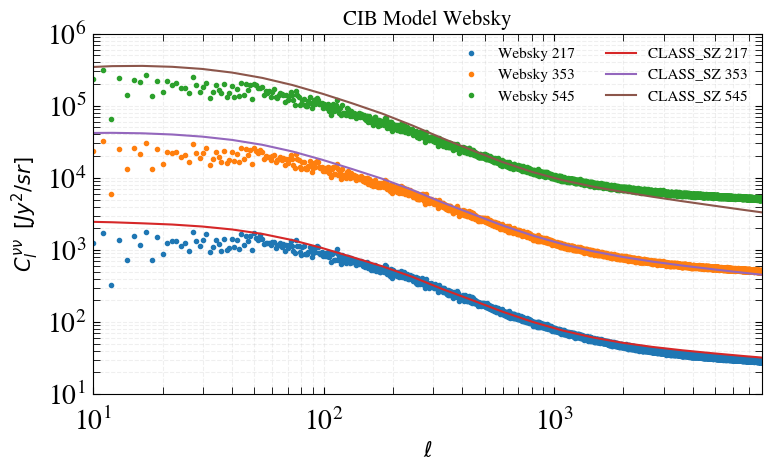

In [61]:
fig, ax1 = plt.subplots(1,1,figsize=(8,5))
ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=12)
plt.setp(ax.get_xticklabels(), fontsize=12)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
ax.set_ylabel(r"$C_l^{\nu \nu} \,\,\, [Jy^2/sr]$", size=15)
ax.set_xlabel(r"$\ell$", size=15)
plt.title('CIB Model Websky', fontsize=15)



plt.plot(ell_ws, 1e12*ws_cib217, ".", label = "Websky 217")
plt.plot(ell_ws, 1e12*ws_cib353, ".", label = "Websky 353")
plt.plot(ell_ws, 1e12*ws_cib545, ".", label = "Websky 545")

for (i,nu) in enumerate(nu_list):
    #CIB websky
    cib_1h = np.asarray(cib[str(nu)+'x'+str(nu)]['1h']) 
    cib_2h = np.asarray(cib[str(nu)+'x'+str(nu)]['2h'])
    # shot_noise = cib_sn[str(nu)][str(nu)+'x'+str(nu)] / Jysr_to_uKcmb(nu)/ Jysr_to_uKcmb(nu)
    # plt.plot(ell_cib, (cib_1h+cib_2h)/cl2dl + shot_noise, "-", label=r'%.1i'%(nu))
    # shot_noise = cib_sn[str(nu)][str(nu)+'x'+str(nu)] / Jysr_to_uKcmb(nu)/ Jysr_to_uKcmb(nu)
    planck_shot_noise = 0.
    if str(nu) == '353':
        planck_shot_noise = 262*ell_cib/ell_cib # see table 9 of Planck Collaboration: CB anisotropies with Planck
    if str(nu) == '217':
        planck_shot_noise = 21*ell_cib/ell_cib # see table 9 of Planck Collaboration: CB anisotropies with Planck
    if str(nu) == '545':
        planck_shot_noise = 1690*ell_cib/ell_cib # see table 9 of Planck Collaboration: CB anisotropies with Planck
    plt.plot(ell_cib, (cib_1h+cib_2h)/cl2dl+planck_shot_noise, "-", label=r'CLASS_SZ %.1i'%(nu))
    

    
    
plt.xlim(1.e1, 8.e3)
plt.ylim(1.e1, 1.e6)

plt.yscale("log")
plt.xscale("log")
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.legend(loc=1,ncol=2, fontsize=11,frameon=False)

fig.tight_layout()
plt.savefig('figures/websky_cib_cls.pdf')